In [44]:
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



In [45]:

df = pd.read_csv('complete_df_to_25.csv')
df = df[2608:].drop(columns = ['Unnamed: 0', 'league', 'teamname',"ban1", "ban2", "ban3", "ban4", "ban5", 
    "pick1", "pick2", "pick3", "pick4", "pick5"] )




In [46]:

df["pga_diff"] = df.groupby("gameid")["PGA"].transform(lambda x: x - x.iloc[::-1].values)
df = df.dropna()


df["kda_10"] = (df["killsat10"] + df["assistsat10"]) / df["deathsat10"].replace(0, 1)
df["opp_kda_10"] = (df["opp_killsat10"] + df["opp_assistsat10"]) / df["opp_deathsat10"].replace(0, 1)


df["kda_15"] = (df["killsat15"] + df["assistsat15"]) / df["deathsat15"].replace(0, 1)
df["opp_kda_15"] = (df["opp_killsat15"] + df["opp_assistsat15"]) / df["opp_deathsat15"].replace(0, 1)

df["kda_20"] = (df["killsat20"] + df["assistsat20"]) / df["deathsat20"].replace(0, 1)
df["opp_kda_20"] = (df["opp_killsat20"] + df["opp_assistsat20"]) / df["opp_deathsat20"].replace(0, 1)


df["kda_25"] = (df["killsat25"] + df["assistsat25"]) / df["deathsat25"].replace(0, 1)
df["opp_kda_25"] = (df["opp_killsat25"] + df["opp_assistsat25"]) / df["opp_deathsat25"].replace(0, 1)

In [53]:
df_html = df[["side","pga_diff", 'kda_10', 'opp_kda_10',
    "mean_champ_wr", "mean_team_wr", "golddiffat10", 
    "xpdiffat10", "csdiffat10"
]]

print(df_html.head().to_markdown(index=False))

| side   |   pga_diff |   kda_10 |   opp_kda_10 |   mean_champ_wr |   mean_team_wr |   golddiffat10 |   xpdiffat10 |   csdiffat10 |
|:-------|-----------:|---------:|-------------:|----------------:|---------------:|---------------:|-------------:|-------------:|
| Blue   |         -1 |        0 |            0 |        0.513931 |       0.466667 |             31 |         -139 |            2 |
| Red    |          1 |        0 |            0 |        0.502757 |       0.555556 |            -31 |          139 |           -2 |
| Blue   |         -1 |        0 |            0 |        0.497727 |       0.606061 |            122 |           64 |            6 |
| Red    |          1 |        0 |            0 |        0.508189 |       0.397167 |           -122 |          -64 |           -6 |
| Blue   |         -1 |        1 |            1 |        0.500533 |       0.444444 |           -314 |        -1023 |          -27 |


Baseline - Decision tree

In [29]:
#pre
X_train, X_test, y_train, y_test = train_test_split(
    df[['num_counters_picked','num_counters_banned', 'side']],
    df['result'], random_state=1
)


preproc = ColumnTransformer(
    transformers=[
        ('side', OneHotEncoder(), ['side'])
    ],
    remainder='passthrough',
)

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=1))
])

hyperparameters = {
    'classifier__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
    'classifier__min_samples_split': [2, 5, 10, 20, 50, 100, 200],
    'classifier__criterion': ['entropy', 'gini']
}

searcher = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, scoring='accuracy')

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)

testing_accuracy = searcher.score(X_test, y_test)

print("Best Parameters:", searcher.best_params_)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__min_samples_split': 2}
Training Accuracy: 0.5238878231478944
Testing Accuracy: 0.5281995067141683


c:\Users\Viki Shi\.conda\envs\dsc80\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Final - Random forest

In [54]:
#10 
numerical_features = ["pga_diff", 'kda_10', 'opp_kda_10',
    "mean_champ_wr", "mean_team_wr", "golddiffat10", 
    "xpdiffat10", "csdiffat10"
]
categorical_features = ['side']

X_train, X_test, y_train, y_test = train_test_split(
    df[categorical_features + numerical_features], 
    df['result'], 
    random_state=1, 
    stratify=df['result']
)

preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),  
        ('num', StandardScaler(), numerical_features)  
    ]
)

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', RandomForestClassifier(random_state=1, n_jobs=-1))
])

hyperparameters = {
    'classifier__n_estimators': [200, 250, 300],  
    'classifier__max_depth': [8, 10, 12, None],
    'classifier__min_samples_split': [18, 20, 22, 24],
    'classifier__criterion': ['gini', 'entropy']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

searcher = GridSearchCV(
    pipeline, 
    hyperparameters, 
    cv=cv_strategy, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2  
)

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)
testing_accuracy = searcher.score(X_test, y_test)

importances = searcher.best_estimator_.named_steps["classifier"].feature_importances_

encoded_cat_features = searcher.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


print("Best Parameters:", searcher.best_params_)
print(f"Testing Accuracy: {testing_accuracy:.4f}")
print("\nFeature Importances:\n", feature_importance_df)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_split': 22, 'classifier__n_estimators': 300}
Testing Accuracy: 0.6240

Feature Importances:
          Feature  Importance
5   mean_team_wr    0.341231
6   golddiffat10    0.211380
7     xpdiffat10    0.120950
4  mean_champ_wr    0.106026
8     csdiffat10    0.067003
3     opp_kda_10    0.059633
2         kda_10    0.053705
1       pga_diff    0.026779
0       side_Red    0.013294


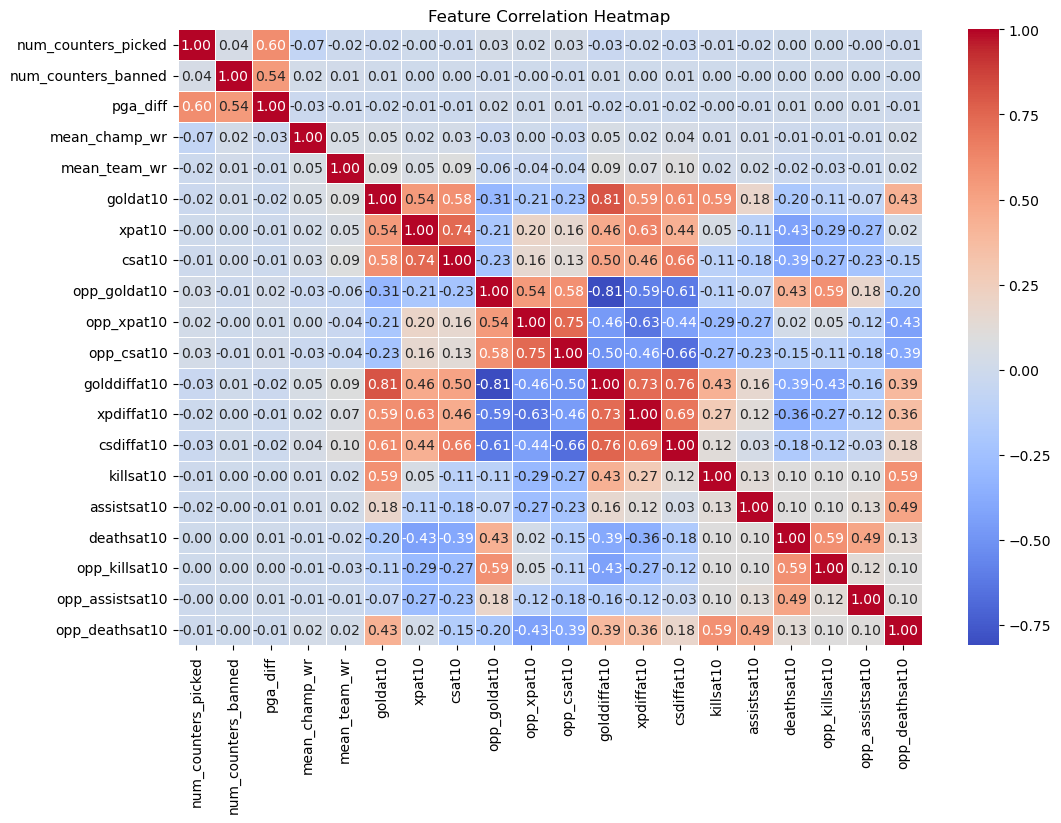

Highly correlated features to consider removing: set()
New dataset shape after removing redundant features: (72980, 20)


In [31]:
#There is overfitting, lets analyze feature with high colliearity


numerical_features = df[[
    "num_counters_picked", "num_counters_banned", "pga_diff", 
    "mean_champ_wr", "mean_team_wr", "goldat10", "xpat10", "csat10", 
    "opp_goldat10", "opp_xpat10", "opp_csat10", "golddiffat10", 
    "xpdiffat10", "csdiffat10", "killsat10", "assistsat10", 
    "deathsat10", "opp_killsat10", "opp_assistsat10", "opp_deathsat10", 
]]

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

threshold = 0.85
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print("Highly correlated features to consider removing:", high_corr_features)

df_reduced = numerical_features.drop(columns=high_corr_features)
print(f"New dataset shape after removing redundant features: {df_reduced.shape}")


Trying logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', LogisticRegression(random_state=1, max_iter=1000, solver='liblinear'))
])

hyperparameters = {
    'classifier__C': [0.01, 0.1, 1, 10],  
    'classifier__penalty': ['l1', 'l2']  
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

searcher = GridSearchCV(
    pipeline, 
    hyperparameters, 
    cv=cv_strategy, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2  
)

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)
testing_accuracy = searcher.score(X_test, y_test)

print("Best Parameters:", searcher.best_params_)
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Testing Accuracy: {testing_accuracy:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}
Training Accuracy: 0.6254
Testing Accuracy: 0.6259


Trying Decision Tree

In [33]:


pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=1))
])

hyperparameters = {
    'classifier__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
    'classifier__min_samples_split': [2, 5, 10, 20, 50, 100, 200],
    'classifier__criterion': ['entropy', 'gini']
}

searcher = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, scoring='accuracy')

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)

testing_accuracy = searcher.score(X_test, y_test)

print("Best Parameters:", searcher.best_params_)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

c:\Users\Viki Shi\.conda\envs\dsc80\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_split': 200}
Training Accuracy: 0.6275509271946652
Testing Accuracy: 0.6133735269936968


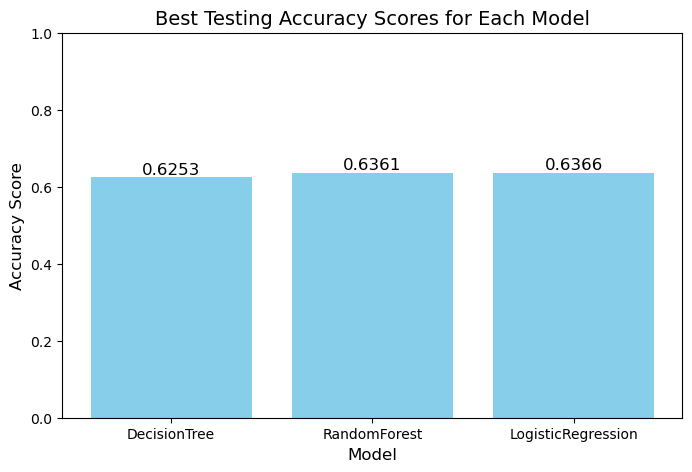

In [34]:

models = ["DecisionTree", "RandomForest", "LogisticRegression"]
accuracy_scores = [0.6253, 0.6361, 0.6366]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy_scores, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

plt.title("Best Testing Accuracy Scores for Each Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.ylim(0, 1)  

plt.show()

In [35]:
#15

numerical_features = ["pga_diff", 'kda_15', 'opp_kda_15',
    "mean_champ_wr", "mean_team_wr", "golddiffat15", 
    "xpdiffat15", "csdiffat15"
]
categorical_features = ['side']

X_train, X_test, y_train, y_test = train_test_split(
    df[categorical_features + numerical_features], 
    df['result'], 
    random_state=1, 
    stratify=df['result']
)

preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),  
        ('num', StandardScaler(), numerical_features)  
    ]
)

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', RandomForestClassifier(random_state=1, n_jobs=-1))
])

hyperparameters = {
    'classifier__n_estimators': [200, 250, 300],  
    'classifier__max_depth': [8, 10, 12, None],
    'classifier__min_samples_split': [18, 20, 22, 24],
    'classifier__criterion': ['gini', 'entropy']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

searcher = GridSearchCV(
    pipeline, 
    hyperparameters, 
    cv=cv_strategy, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2  
)

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)
testing_accuracy = searcher.score(X_test, y_test)

importances = searcher.best_estimator_.named_steps["classifier"].feature_importances_

encoded_cat_features = searcher.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(f"Testing Accuracy: {testing_accuracy:.4f}")
print("\nFeature Importances:\n", feature_importance_df)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Testing Accuracy: 0.6431

Feature Importances:
          Feature  Importance
5   mean_team_wr    0.254363
6   golddiffat15    0.244850
7     xpdiffat15    0.135762
2         kda_15    0.094817
3     opp_kda_15    0.093424
4  mean_champ_wr    0.085811
8     csdiffat15    0.058783
1       pga_diff    0.022361
0       side_Red    0.009829


In [36]:
#20

numerical_features = ["pga_diff", 'kda_20', 'opp_kda_20',
    "mean_champ_wr", "mean_team_wr", "golddiffat20", 
    "xpdiffat20", "csdiffat20"
]
categorical_features = ['side']

X_train, X_test, y_train, y_test = train_test_split(
    df[categorical_features + numerical_features], 
    df['result'], 
    random_state=1, 
    stratify=df['result']
)

preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),  
        ('num', StandardScaler(), numerical_features)  
    ]
)

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', RandomForestClassifier(random_state=1, n_jobs=-1))
])

hyperparameters = {
    'classifier__n_estimators': [200, 250, 300],  
    'classifier__max_depth': [8, 10, 12, None],
    'classifier__min_samples_split': [18, 20, 22, 24],
    'classifier__criterion': ['gini', 'entropy']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

searcher = GridSearchCV(
    pipeline, 
    hyperparameters, 
    cv=cv_strategy, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2  
)

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)
testing_accuracy = searcher.score(X_test, y_test)

importances = searcher.best_estimator_.named_steps["classifier"].feature_importances_

encoded_cat_features = searcher.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(f"Testing Accuracy: {testing_accuracy:.4f}")
print("\nFeature Importances:\n", feature_importance_df)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Testing Accuracy: 0.6884

Feature Importances:
          Feature  Importance
6   golddiffat20    0.255716
3     opp_kda_20    0.173337
2         kda_20    0.171277
5   mean_team_wr    0.163675
7     xpdiffat20    0.111856
4  mean_champ_wr    0.053908
8     csdiffat20    0.047994
1       pga_diff    0.016150
0       side_Red    0.006087


In [37]:
#25

numerical_features = ["pga_diff", 'kda_25', 'opp_kda_25',
    "mean_champ_wr", "mean_team_wr", "golddiffat25", 
    "xpdiffat25", "csdiffat25"
]
categorical_features = ['side']

X_train, X_test, y_train, y_test = train_test_split(
    df[categorical_features + numerical_features], 
    df['result'], 
    random_state=1, 
    stratify=df['result']
)

preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),  
        ('num', StandardScaler(), numerical_features)  
    ]
)

pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', RandomForestClassifier(random_state=1, n_jobs=-1))
])

hyperparameters = {
    'classifier__n_estimators': [200, 250, 300],  
    'classifier__max_depth': [8, 10, 12, None],
    'classifier__min_samples_split': [18, 20, 22, 24],
    'classifier__criterion': ['gini', 'entropy']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

searcher = GridSearchCV(
    pipeline, 
    hyperparameters, 
    cv=cv_strategy, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2  
)

searcher.fit(X_train, y_train)

training_accuracy = searcher.score(X_train, y_train)
testing_accuracy = searcher.score(X_test, y_test)

importances = searcher.best_estimator_.named_steps["classifier"].feature_importances_

encoded_cat_features = searcher.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_features) + numerical_features

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(f"Testing Accuracy: {testing_accuracy:.4f}")
print("\nFeature Importances:\n", feature_importance_df)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Testing Accuracy: 0.7618

Feature Importances:
          Feature  Importance
7     xpdiffat25    0.308282
3     opp_kda_25    0.170636
2         kda_25    0.168735
6   golddiffat25    0.128606
5   mean_team_wr    0.085118
8     csdiffat25    0.074613
4  mean_champ_wr    0.043777
1       pga_diff    0.015531
0       side_Red    0.004703


In [55]:

models = ["Pre-Game", "10 Minute Mark", "15 Minute Mark", "20 Minute Mark", "25 Minute Mark"]
accuracy_scores = [0.5282, 0.6240,  0.6431,  0.6884, 0.7618]

df = pd.DataFrame({"Game Time": models, "Accuracy Score": accuracy_scores})

fig = px.line(df, x="Game Time", y="Accuracy Score", title="Testing Accuracy", markers=True)

fig.write_html('models.html', include_plotlyjs='cdn')
